# Explore signal/price movement relationship

This is an example notebook to explore whether a trading signal results to profitable trades.

- It explores a small set of pairs on Uni v3 on Polygon
- Both long and short are considered (though shorts might be theoretical only, if such a lending market doest not exist in the point of time)

In [56]:
import datetime

import pandas as pd

from tradingstrategy.client import Client
from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.utils.default_strategies import get_default_strategies_path
from tradeexecutor.strategy.execution_context import notebook_execution_context
from tradeexecutor.utils.default_strategies import get_default_strategies_path
from tradeexecutor.strategy.strategy_module import read_strategy_module
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_trading_and_lending_data
from tradeexecutor.strategy.universe_model import UniverseOptions


def create_trading_universe(
    ts: datetime.datetime,
    client: Client,
    execution_context,
    universe_options,
) -> TradingStrategyUniverse:
    
    dataset = load_trading_and_lending_data(
        client,
        execution_context=execution_context,
        universe_options=universe_options,
        # Ask for all Polygon data
        chain_id=ChainId.polygon,
        exchange_slugs={"uniswap-v3"},
        reserve_asset_symbols={"USDC"},
        asset_symbols={"LINK", "WMATIC", "WETH", "BAL"},
        # trading_fee=0.0030,  # Only use pairs at 0.05% fee tier
        time_bucket=TimeBucket.h4,
    )

    universe = TradingStrategyUniverse.create_from_dataset(dataset)

    return universe


client = Client.create_jupyter_client()

strategy_universe = create_trading_universe(
    datetime.datetime.utcnow(),
    client,
    notebook_execution_context,
    # Uniswap v3 gets deployed around 2022-07-07
    UniverseOptions(start_at=pd.Timestamp("2022-01-01"), end_at=pd.Timestamp("2023-11-01")),
)

data_universe = strategy_universe.data_universe

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


### Interactive viewer mode

Set Plotly chart output mode to interactive viewing.

In [57]:
from tradeexecutor.utils.notebook import OutputMode, setup_charting_and_output

# setup_charting_and_output(OutputMode.interactive, image_format="svg")
setup_charting_and_output(
    OutputMode.static, 
    image_format="png",
    width=1500,
    height=1200,    
)

## Explore signal vs price change

Create a function `calculate_signal_vs_profit` which calculates 
- Signal (naive momentum)
- Profit: the last and the best future price we can get
- Allows us to play around with different time windows
- Split between shorts and longs


In [58]:
# Set up parameters of time windows
# we use for this notebook run
signal_window = pd.Timedelta(days=2)
profit_window = pd.Timedelta(days=1)

In [59]:
import numpy as np
from pandas.tseries.frequencies import to_offset

from tradingstrategy.utils.forward_fill import forward_fill
from tradingstrategy.pair import DEXPair


def calculate_signal_vs_profit(
    df, 
    signal_window: pd.Timedelta, 
    profit_window: pd.Timedelta,
    data_time_bucket: pd.Timedelta,        
) -> pd.DataFrame:
    """Calculate signals and profits for all incoming candles."""
    
    # Create entries for past price to be used for signal
    # and future price (used for the price correlation)
    signal_offset = to_offset(signal_window)
    profit_offset = to_offset(profit_window)

    df["prev"] = df["close"].shift(freq=signal_offset)
    df["next"] = df["open"].shift(freq=-profit_offset)

    # Calculate signal from the past and price difference to the future
    df["signal"] = (df["prev"] - df["open"]) / df["open"]
    df["price_diff"] = (df["next"] - df["open"]) / df["open"]  # Get the profit on the final day of profit window

    # On negative signals, we go short.
    # On zero signal and lack of data set side to NA
    df["side"] = pd.NA
    df.loc[df["signal"] > 0, "side"] = "long"
    df.loc[df["signal"] < 0, "side"] = "short"

    number_of_candles = profit_window / data_time_bucket
    assert number_of_candles > 0 and number_of_candles.is_integer(), f"Could not calculate candle count that fits into profit window {profit_window} for data time frame {data_time_bucket}"
    number_of_candles = int(number_of_candles)

    # Max and min price wihtin the profit window will determine the profit for longs and shorts respective
    df["max_future_price"] = df["close"].rolling(number_of_candles).max().shift(-number_of_candles) # Get the max profit on the profit window, assuming take profit %
    df["min_future_price"] = df["close"].rolling(number_of_candles).min().shift(-number_of_candles) # Get the max profit on the profit window, assuming take profit %    
    
    # Calculate profit separately for longs and shorts
    # using Pandas Mask
    # https://stackoverflow.com/a/33770421/315168
    #
    # We calculate both profit after X time,
    # and also max take profit, assuming
    # we could do a perfect trailing stop loss
    #
    longs = (df["side"] == "long")
    shorts = (df["side"] == "short")
    df.loc[longs, "profit"] = df["price_diff"]
    df.loc[shorts, "profit"] = -df["price_diff"]
    df.loc[longs, "profit_max"] = (df["max_future_price"] - df["open"]) / df["open"]  # Get the profit based on max price
    df.loc[shorts, "profit_max"] = -(df["min_future_price"] - df["open"]) / df["open"]  # Get the profit based on max price

    df.loc[longs, "desc"] = df.agg('{0[pair]} long'.format, axis=1)
    df.loc[shorts, "desc"] = df.agg('{0[pair]} short'.format, axis=1)
    
    return df

Create a function `calculate_signal_vs_price_for_pair` which calculates 
- Calculates the signal vs. for certain trading pair
- Bundle few different pairs to the same `DataFrame` so we can examine them together


In [60]:
import humanize


# Use later in chart titles
signal_window_label = humanize.naturaldelta(signal_window)
profit_window_label = humanize.naturaldelta(profit_window)

def calculate_signal_vs_price_for_pair(
    pair: DEXPair
) -> pd.DataFrame:
    """Calculate signal vs. profit ratio for an individual pair."""
    df = data_universe.candles.get_candles_by_pair(pair)
    assert df is not None

    df = df.copy()

    # Make sure there are no gaps in the data
    df = forward_fill(
        df, 
        freq=data_universe.time_bucket.to_frequency(), 
        columns=("open", "high", "low", "close")
    )

    df["pair"] = pair.get_ticker()
    df = calculate_signal_vs_profit(
        df,
        signal_window,
        profit_window,
        data_time_bucket=data_universe.time_bucket.to_pandas_timedelta(),
    )

    
    return df

# Pull out trading pair details for pairs we are examining
pairs = data_universe.pairs
examined_pairs = [
    pairs.get_pair_by_human_description([ChainId.polygon, "uniswap-v3", "WETH", "USDC", 0.0005]),
    pairs.get_pair_by_human_description([ChainId.polygon, "uniswap-v3", "LINK", "USDC", 0.0005]),
    pairs.get_pair_by_human_description([ChainId.polygon, "uniswap-v3", "WMATIC", "USDC", 0.0005]),
    pairs.get_pair_by_human_description([ChainId.polygon, "uniswap-v3", "BAL", "USDC", 0.0030]),
]

# Show what pairs we are examining
print("Examined pairs:")
examined_pairs_df = pd.DataFrame([p.to_dict() for p in examined_pairs])
display(examined_pairs_df[["exchange_slug", "base_token_symbol", "quote_token_symbol", "fee"]].style.hide(axis="index").set_properties(**{'text-align': 'left'}))

pair_dfs = [calculate_signal_vs_price_for_pair(pair) for pair in examined_pairs]
df = pd.concat(pair_dfs)
pd.set_option('display.min_rows', 36)
print(f"Example price data, we have total {len(df):,} candles")
display(df)

Examined pairs:


Example price data, we have total 10,490 candles


open         high          low        close  \
timestamp                                                                 
2022-07-07 08:00:00  1184.941609  1190.285594  1178.206991  1183.875695   
2022-07-07 12:00:00  1183.994082  1226.533348  1178.560488  1218.343450   
2022-07-07 16:00:00  1218.343450  1252.561586  1212.024823  1248.060696   
2022-07-07 20:00:00  1247.811122  1248.809720  1224.450116  1237.621415   
2022-07-08 00:00:00  1237.497665  1271.872162  1231.202807  1257.958927   
2022-07-08 04:00:00  1258.084723  1267.428613  1235.148769  1239.851028   
2022-07-08 08:00:00  1239.851028  1242.705824  1204.895286  1219.684298   
2022-07-08 12:00:00  1219.684298  1238.859593  1194.458684  1234.654833   
2022-07-08 16:00:00  1234.654833  1247.187403  1213.844133  1238.735720   
2022-07-08 20:00:00  1238.983479  1252.561586  1212.752220  1215.787741   
2022-07-09 00:00:00  1215.909320  1220.172245  1204.654343  1215.180030   
2022-07-09 04:00:00  1215.301548  1225.430019  1210.813465  1223.838075   
2022-07-09 08:00:00  1223.838075  1227.514918  1205.256791  1209.119596   
2022-07-09 12:00:00  1209.240508  1221.026622  1206.583236  1215.058524   
2022-07-09 16:00:00  1214.937030  1230.956604  1209.724277  1217.490951   
2022-07-09 20:00:00  1217.490951  1225.430019  1212.994782  1216.882388   
2022-07-10 00:00:00  1216.882388  1218.099818  1185.178609  1188.501593   
2022-07-10 04:00:00  1188.501593  1194.100418  1184.941609  1189.214873   
...                          ...          ...          ...          ...   
2023-10-29 00:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-29 04:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-29 08:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-29 12:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-29 16:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-29 20:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-30 00:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-30 04:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-30 08:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-30 12:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-30 16:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-30 20:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-31 00:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-31 04:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-31 08:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-31 12:00:00     3.287223     3.287223     3.287223     3.287223   
2023-10-31 16:00:00     3.335900     3.335900     3.335900     3.335900   
2023-10-31 20:00:00     3.401245     3.423766     3.401245     3.423766   

                          pair         prev         next    signal  \
timestamp                                                            
2022-07-07 08:00:00  WETH-USDC          NaN  1239.851028       NaN   
2022-07-07 12:00:00  WETH-USDC          NaN  1219.684298       NaN   
2022-07-07 16:00:00  WETH-USDC          NaN  1234.654833       NaN   
2022-07-07 20:00:00  WETH-USDC          NaN  1238.983479       NaN   
2022-07-08 00:00:00  WETH-USDC          NaN  1215.909320       NaN   
2022-07-08 04:00:00  WETH-USDC          NaN  1215.301548       NaN   
2022-07-08 08:00:00  WETH-USDC          NaN  1223.838075       NaN   
2022-07-08 12:00:00  WETH-USDC          NaN  1209.240508       NaN   
2022-07-08 16:00:00  WETH-USDC          NaN  1214.937030       NaN   
2022-07-08 20:00:00  WETH-USDC          NaN  1217.490951       NaN   
2022-07-09 00:00:00  WETH-USDC          NaN  1216.882388       NaN   
2022-07-09 04:00:00  WETH-USDC          NaN  1188.501593       NaN   
2022-07-09 08:00:00  WETH-USDC  1183.875695  1189.214873 -0.032653   
2022-07-09 12:00:00  WETH-USDC  1218.343450  1181.98

## Plot signal vs. price samples

Different scatter charts to examine if there is a correlation between the signal and the profit.

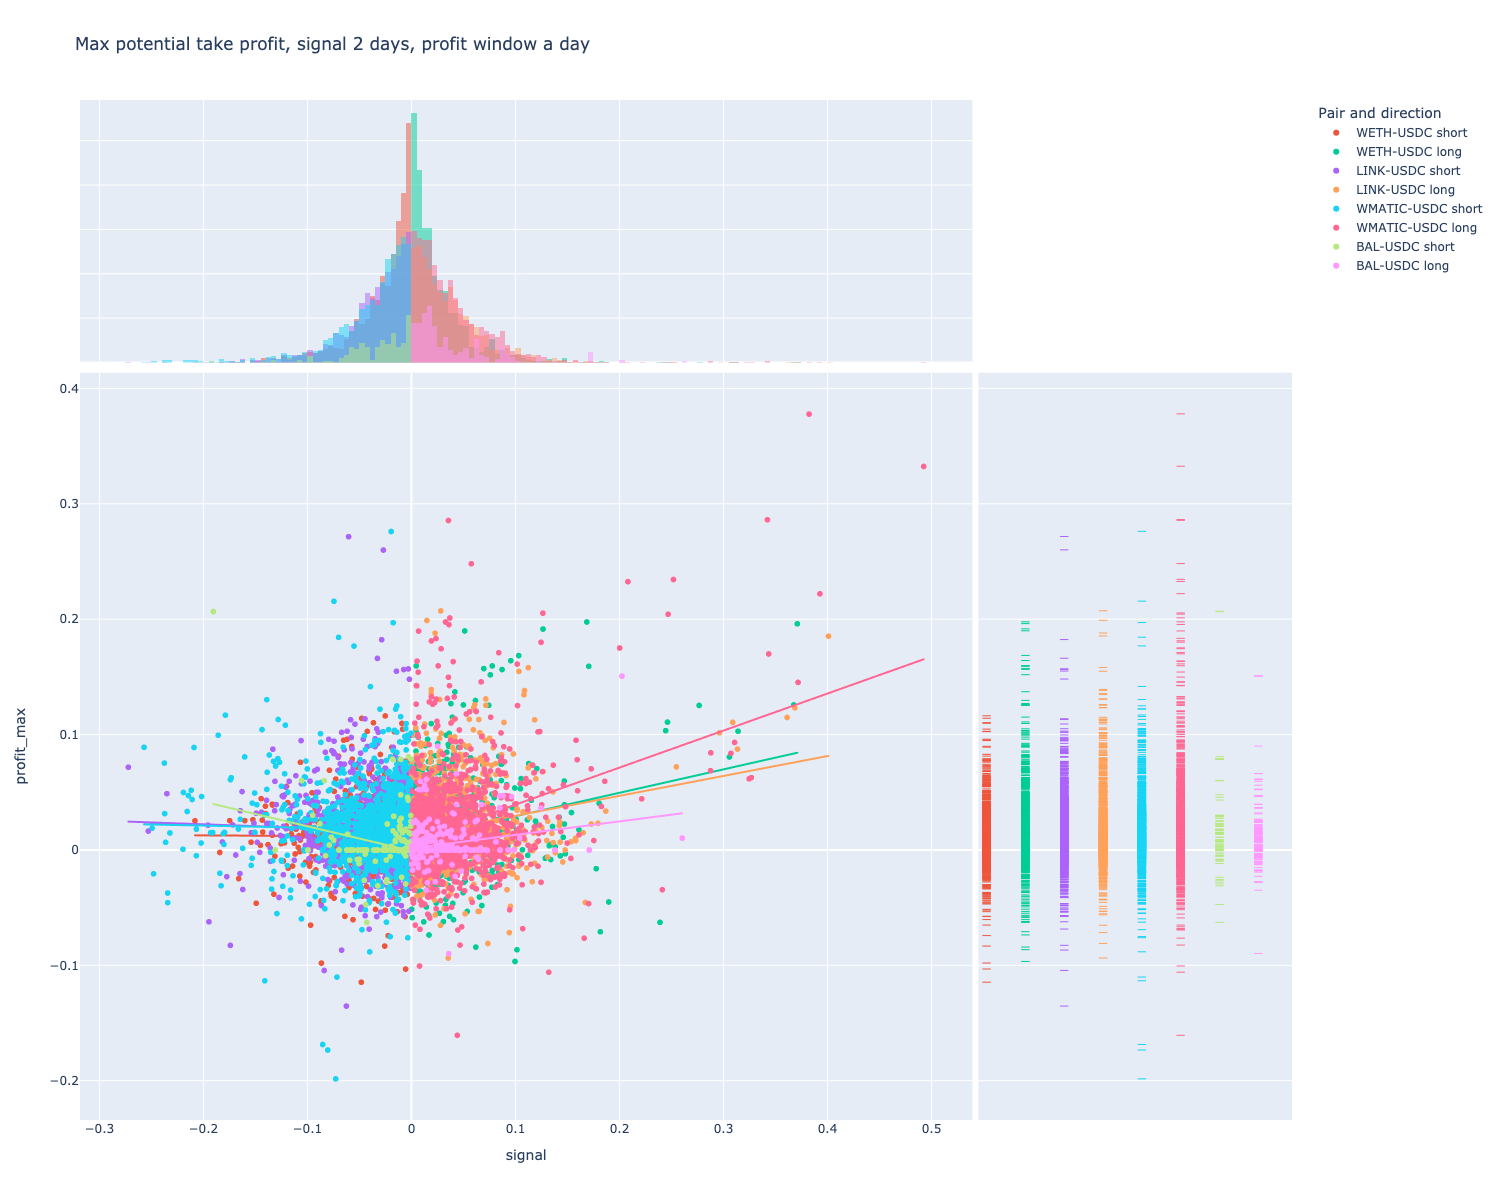

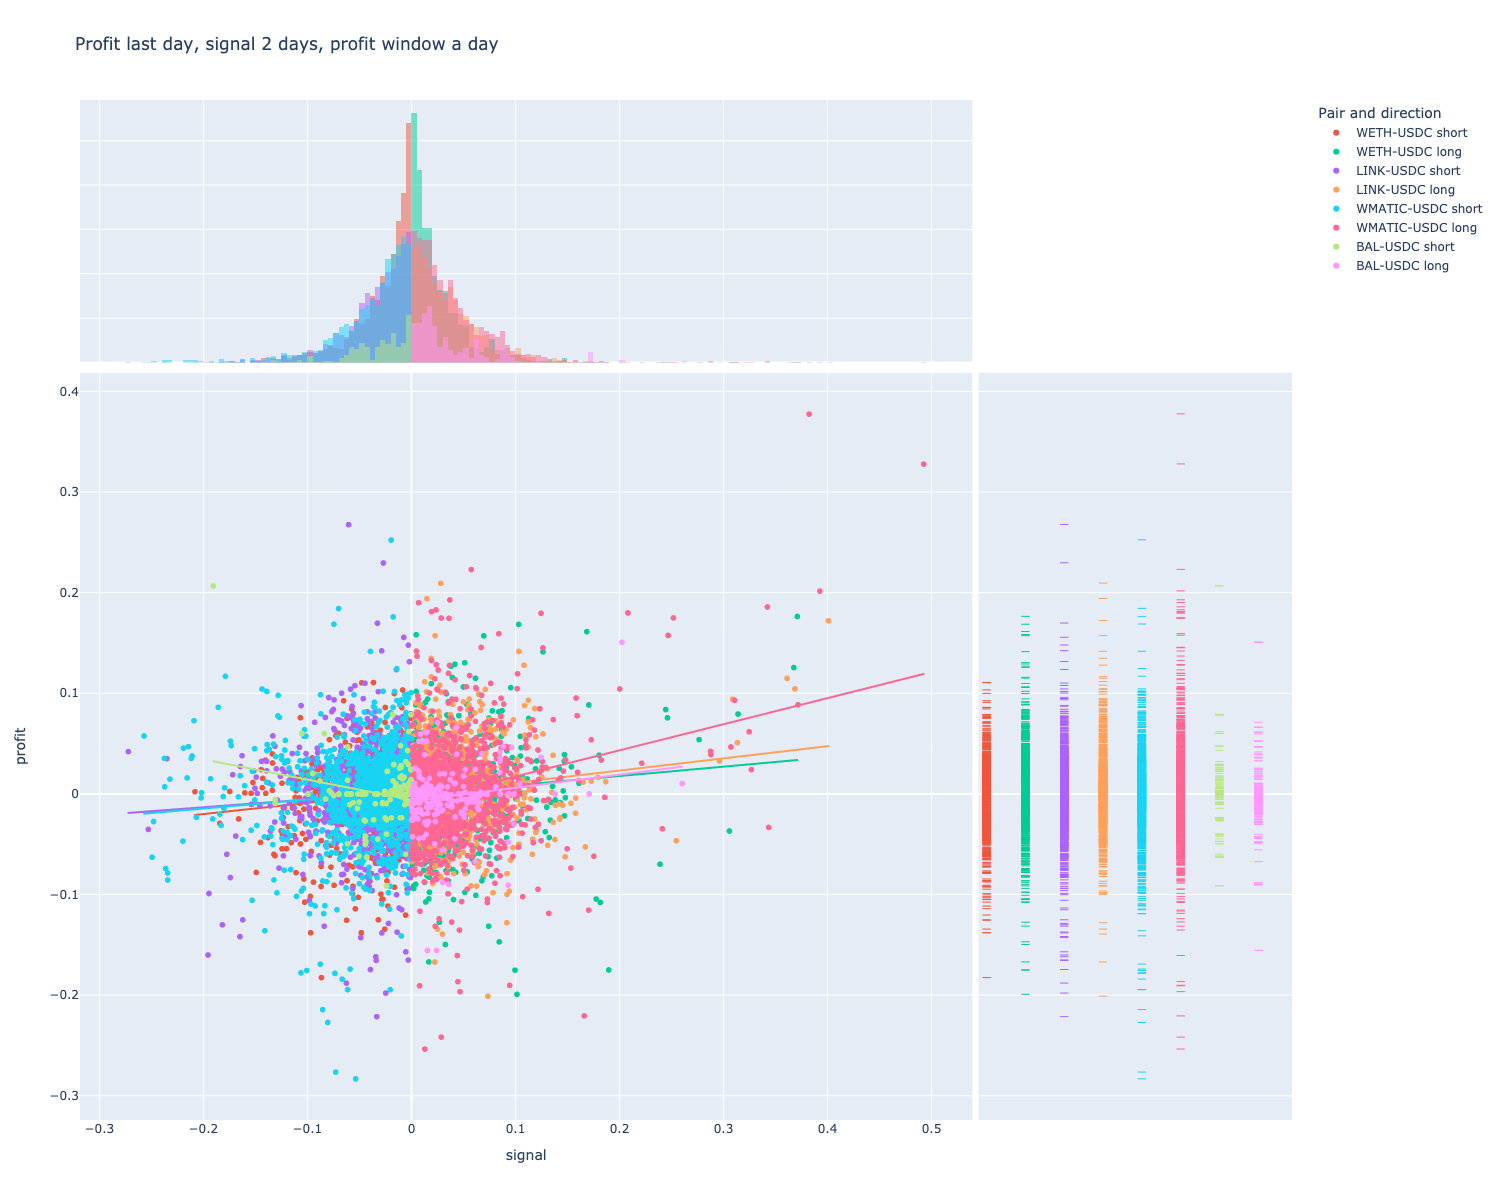

In [61]:
import plotly.express as px

fig = px.scatter(
    df, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    color="desc", 
    title=f"Max potential take profit, signal {signal_window_label}, profit window {profit_window_label}",
    marginal_x="histogram", 
    marginal_y="rug"
)
fig.update_layout(legend=dict(title='Pair and direction'))
fig.show()

fig = px.scatter(
    df, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    color="desc", 
    title=f"Profit last day, signal {signal_window_label}, profit window {profit_window_label}",
    marginal_x="histogram", 
    marginal_y="rug"    
)
fig.update_layout(legend=dict(title='Pair and direction'))
fig.show()

### Long only vs. short 

Examine trade types separately to better see if one side is clearly superior.

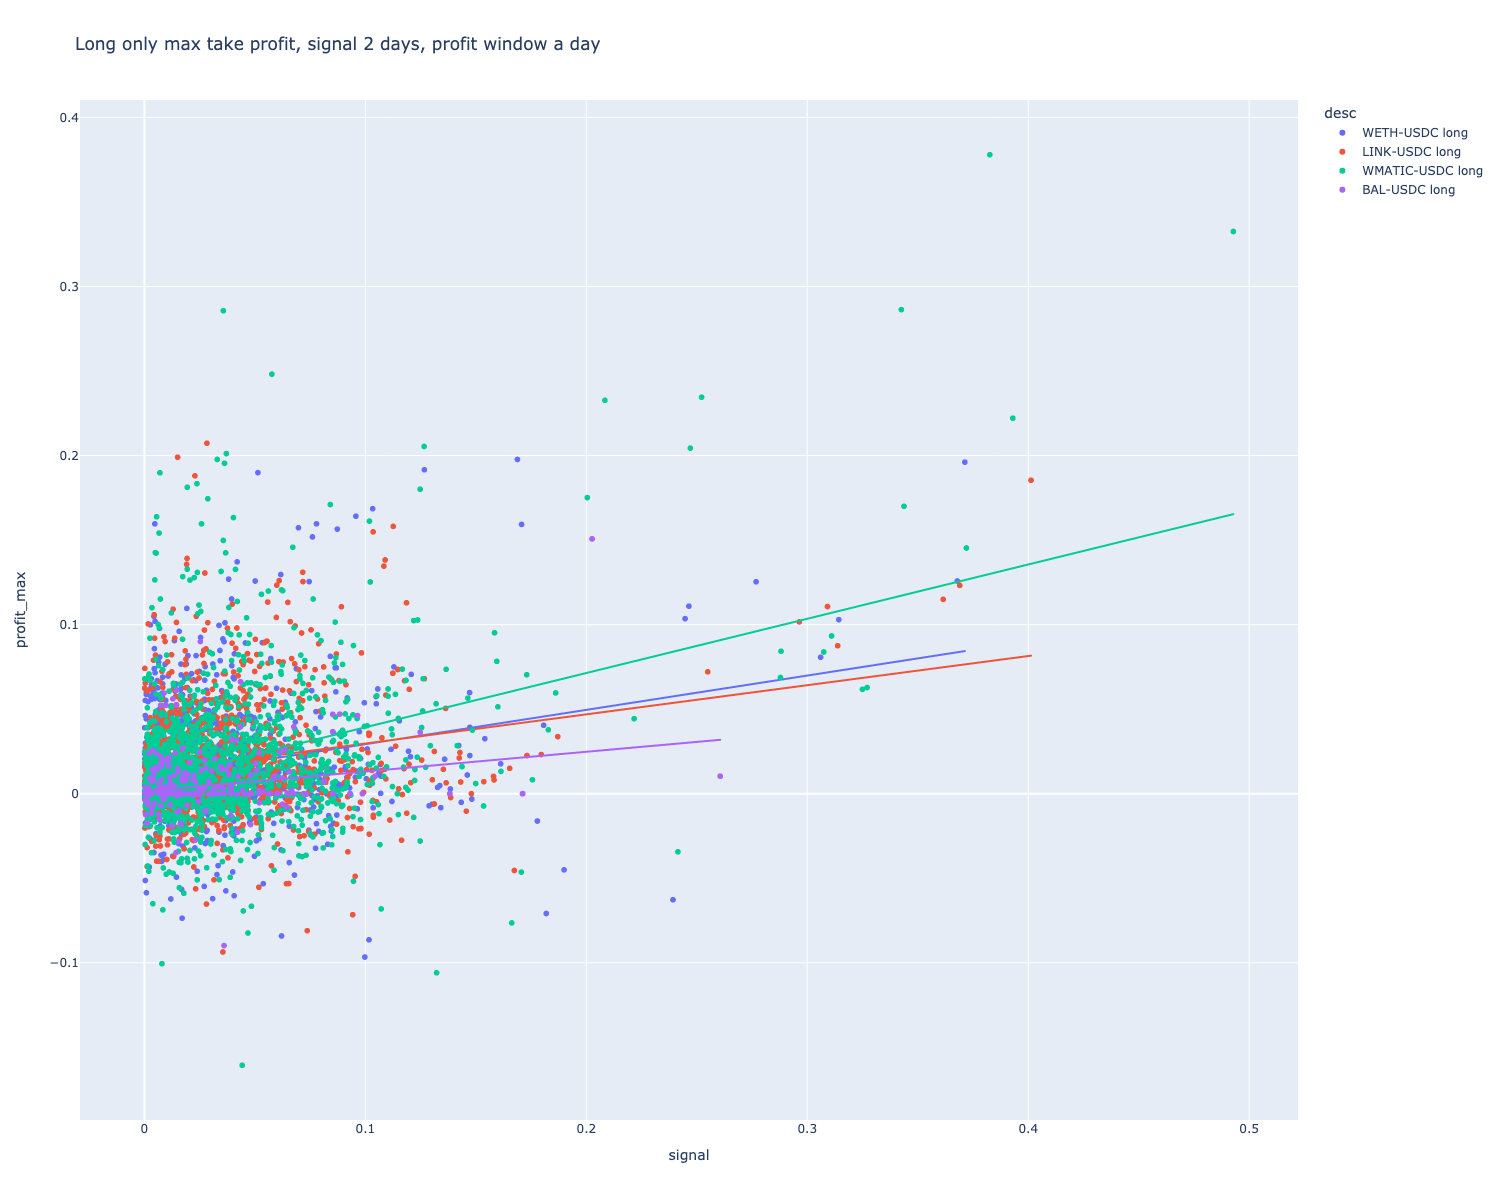

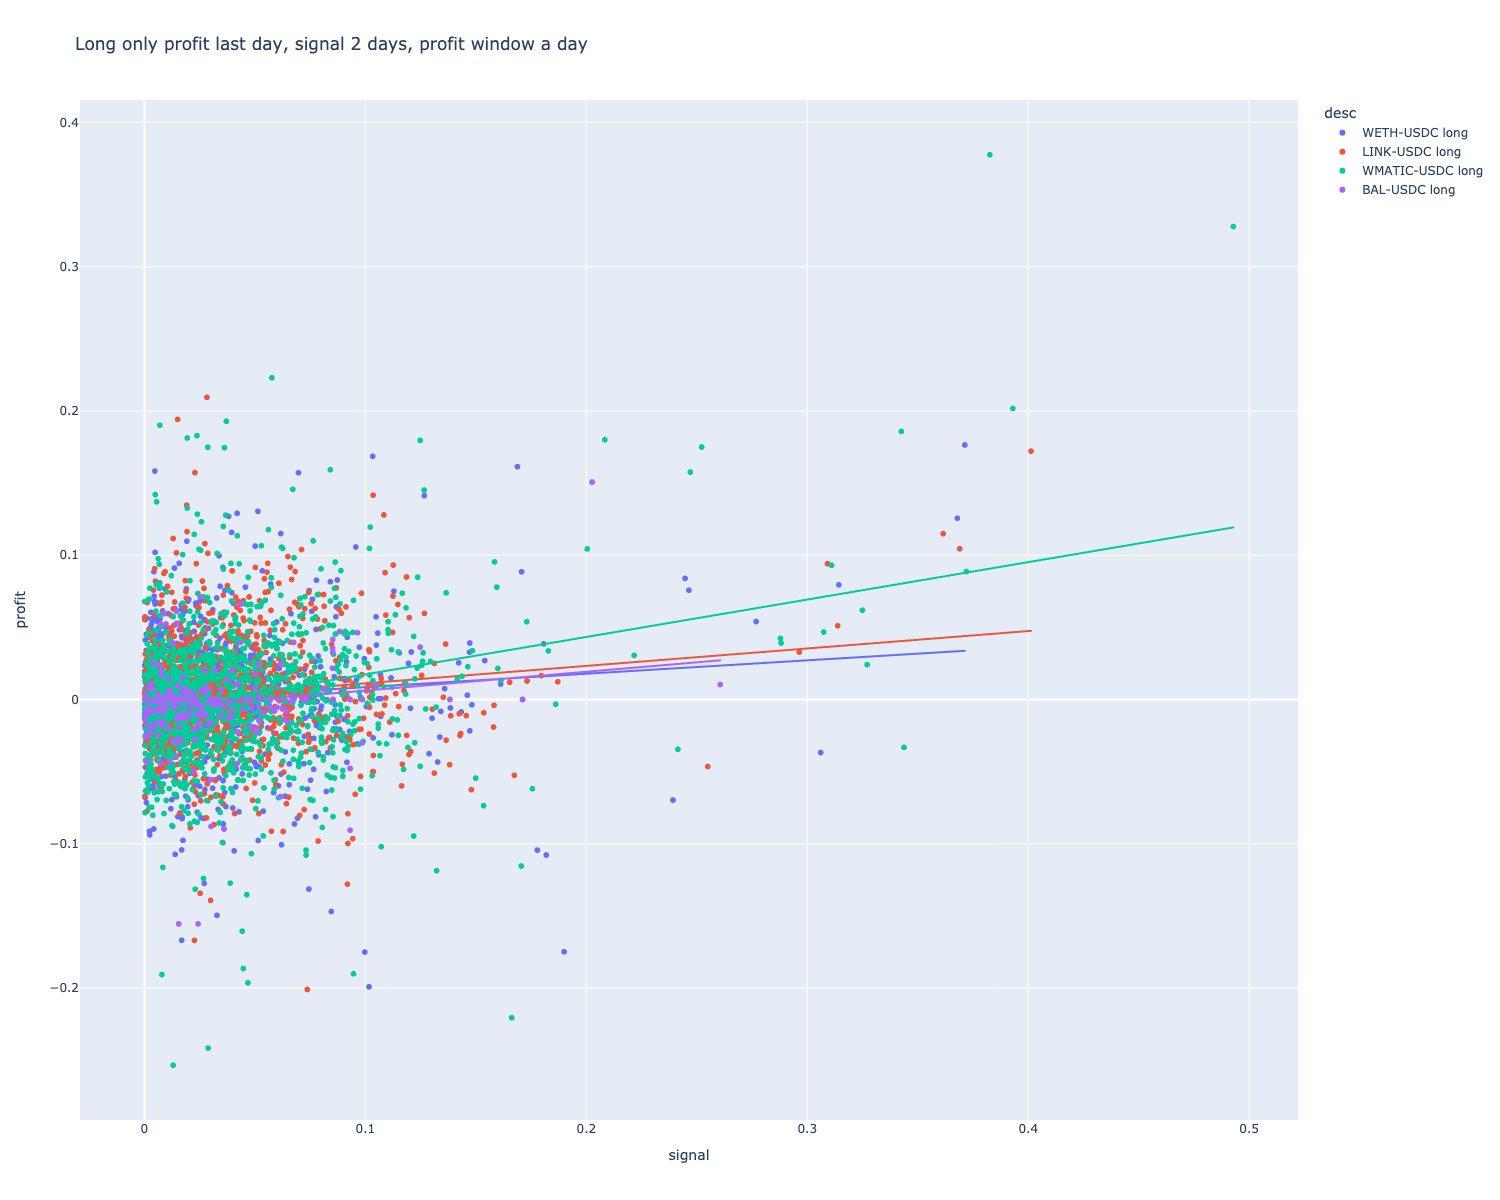

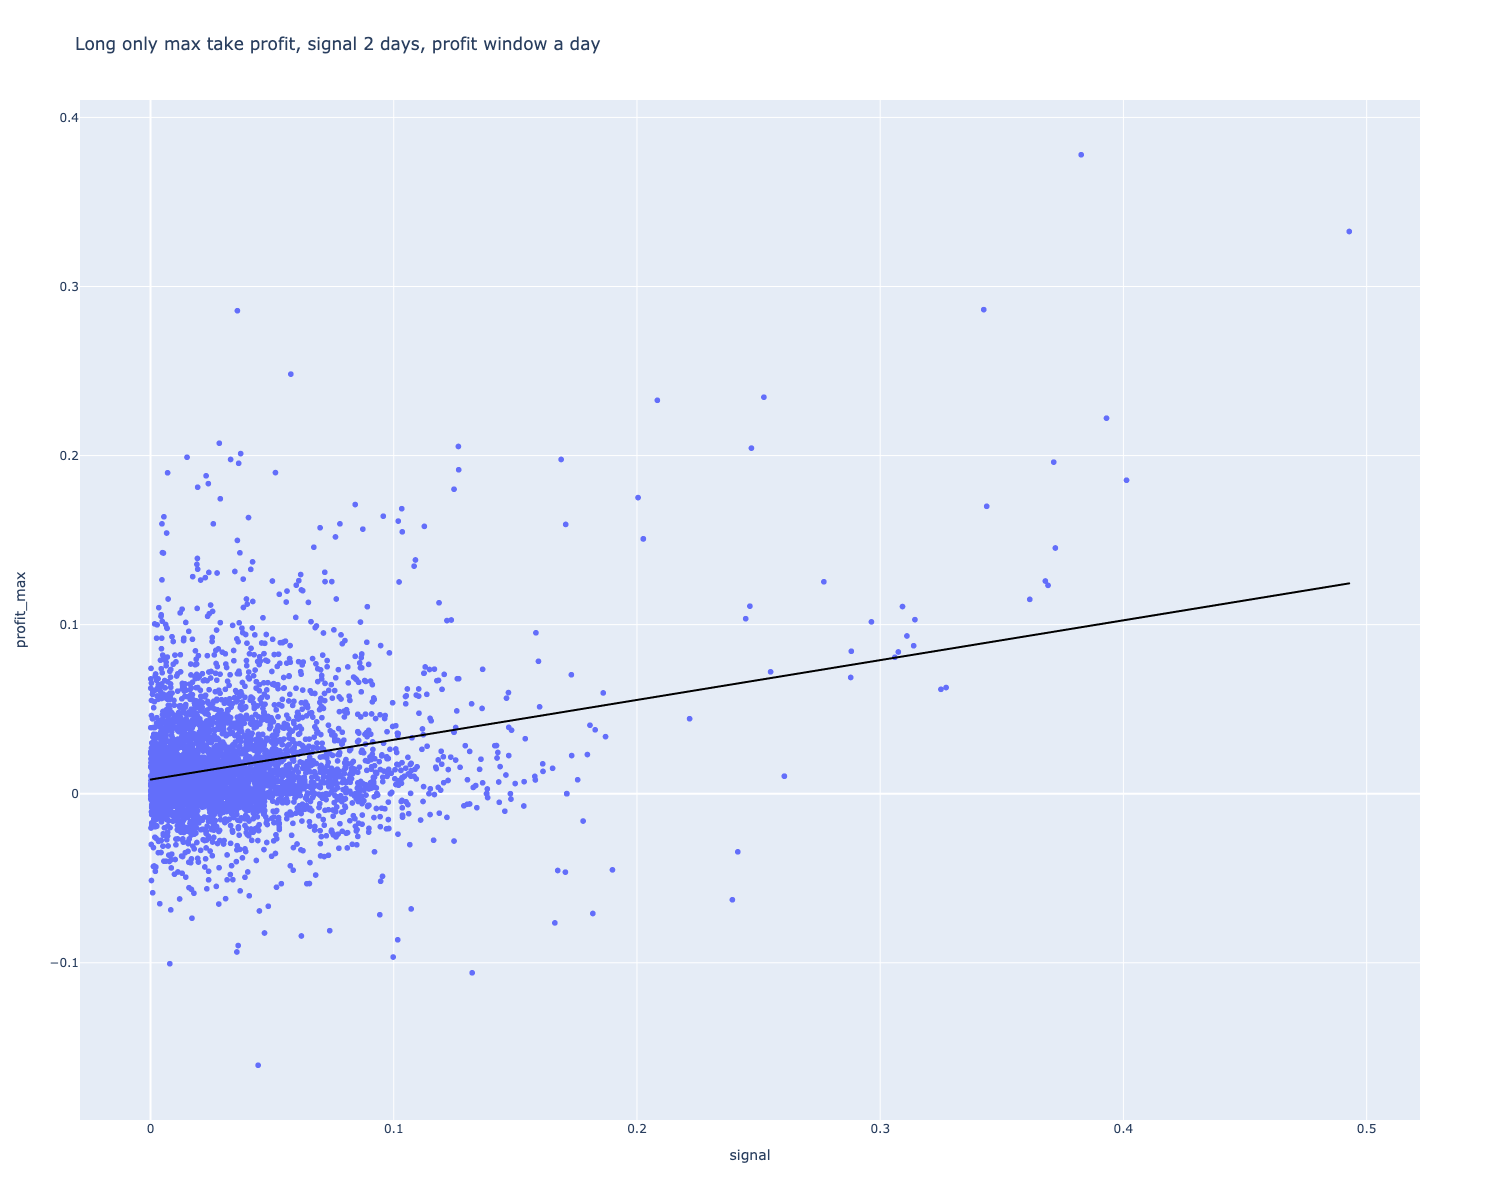

In [62]:
df_long_only = df.loc[df["side"] == "long"]

fig = px.scatter(
    df_long_only, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    color="desc", 
    title=f"Long only max take profit, signal {signal_window_label}, profit window {profit_window_label}",

)
fig.show()

fig = px.scatter(
    df_long_only, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    color="desc", 
    title=f"Long only profit last day, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

fig = px.scatter(
    df_long_only, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Long only max take profit, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()


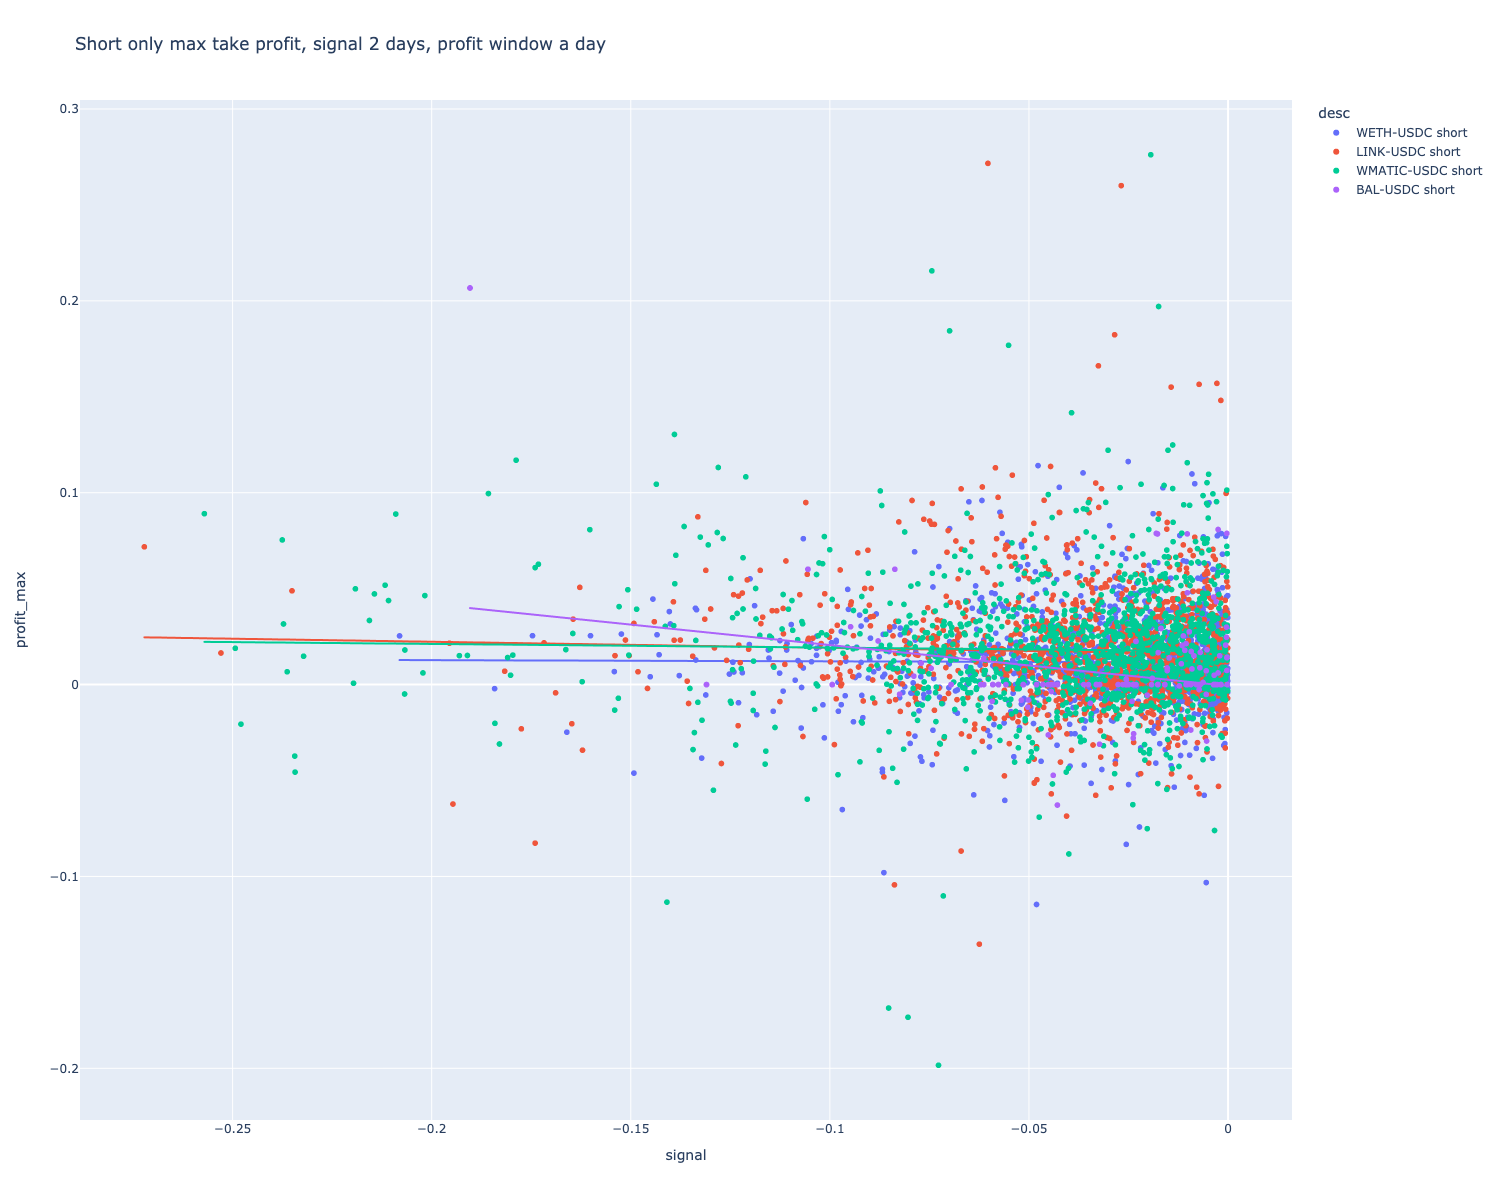

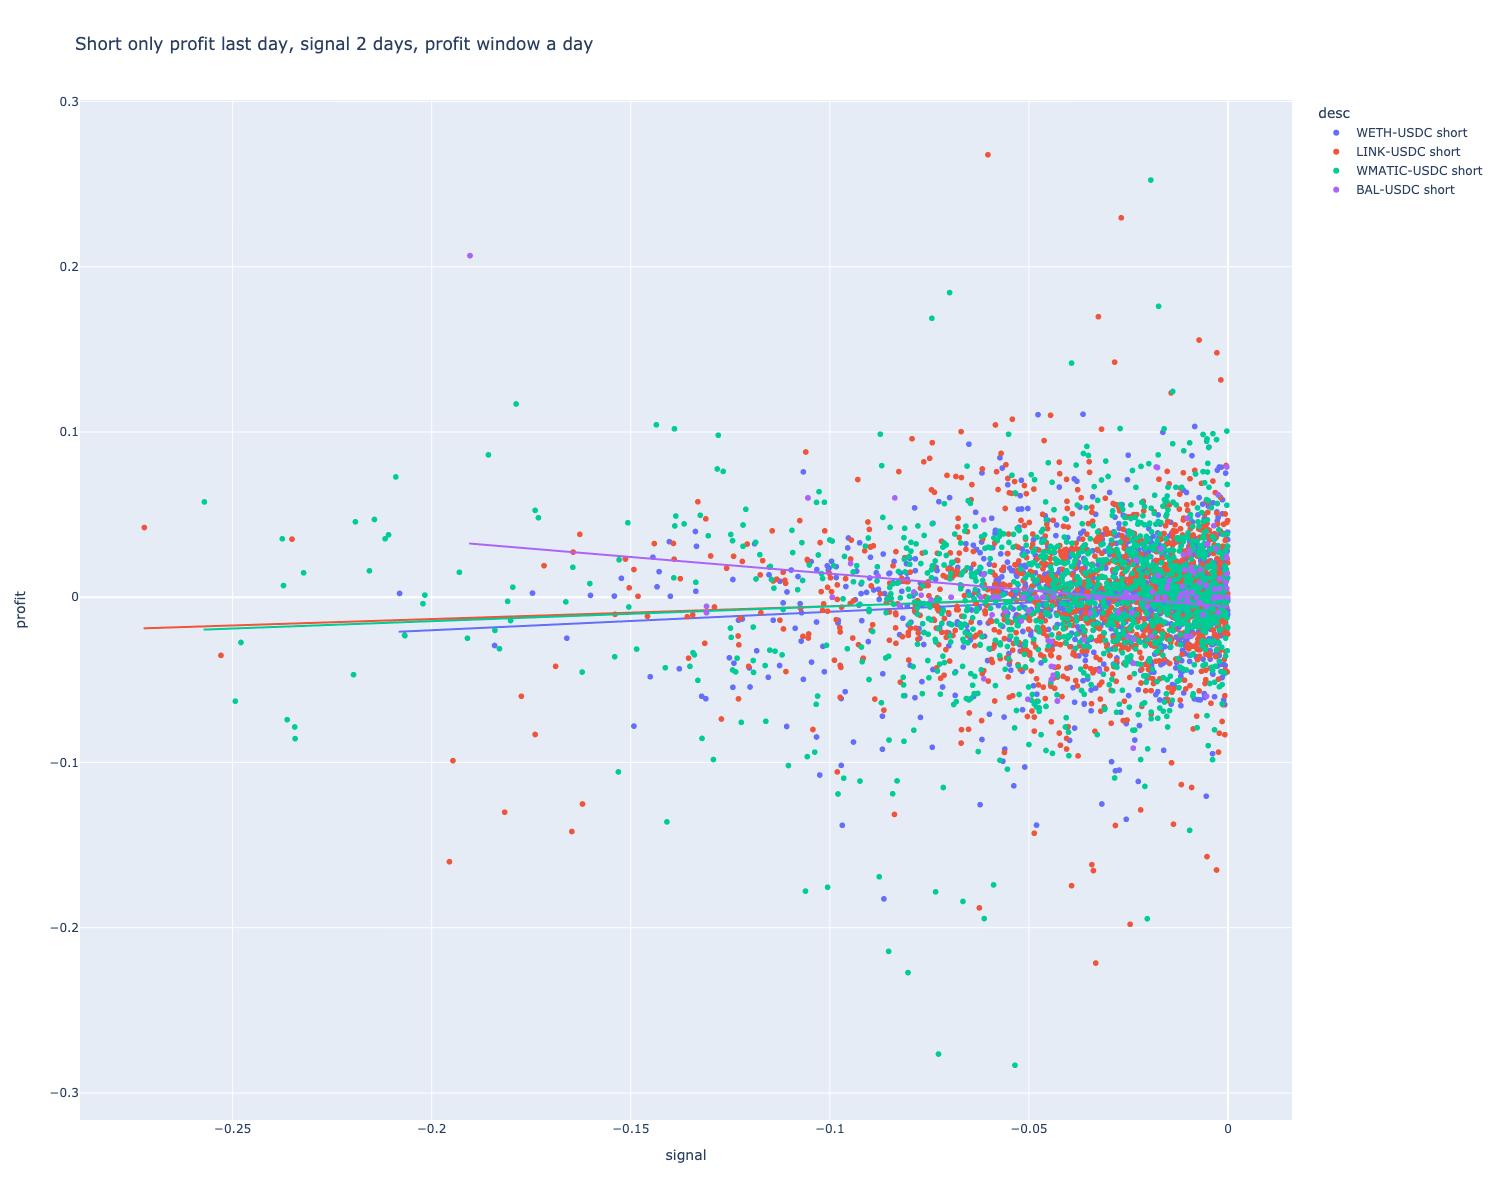

In [63]:
df_short_only = df.loc[df["side"] == "short"]

fig = px.scatter(
    df_short_only, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    color="desc", 
    title=f"Short only max take profit, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

fig = px.scatter(
    df_short_only, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    color="desc", 
    title=f"Short only profit last day, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

### Filtered signal

Remove low signals below a certain threshold and see if it affects the correlation between the signal and the profit.

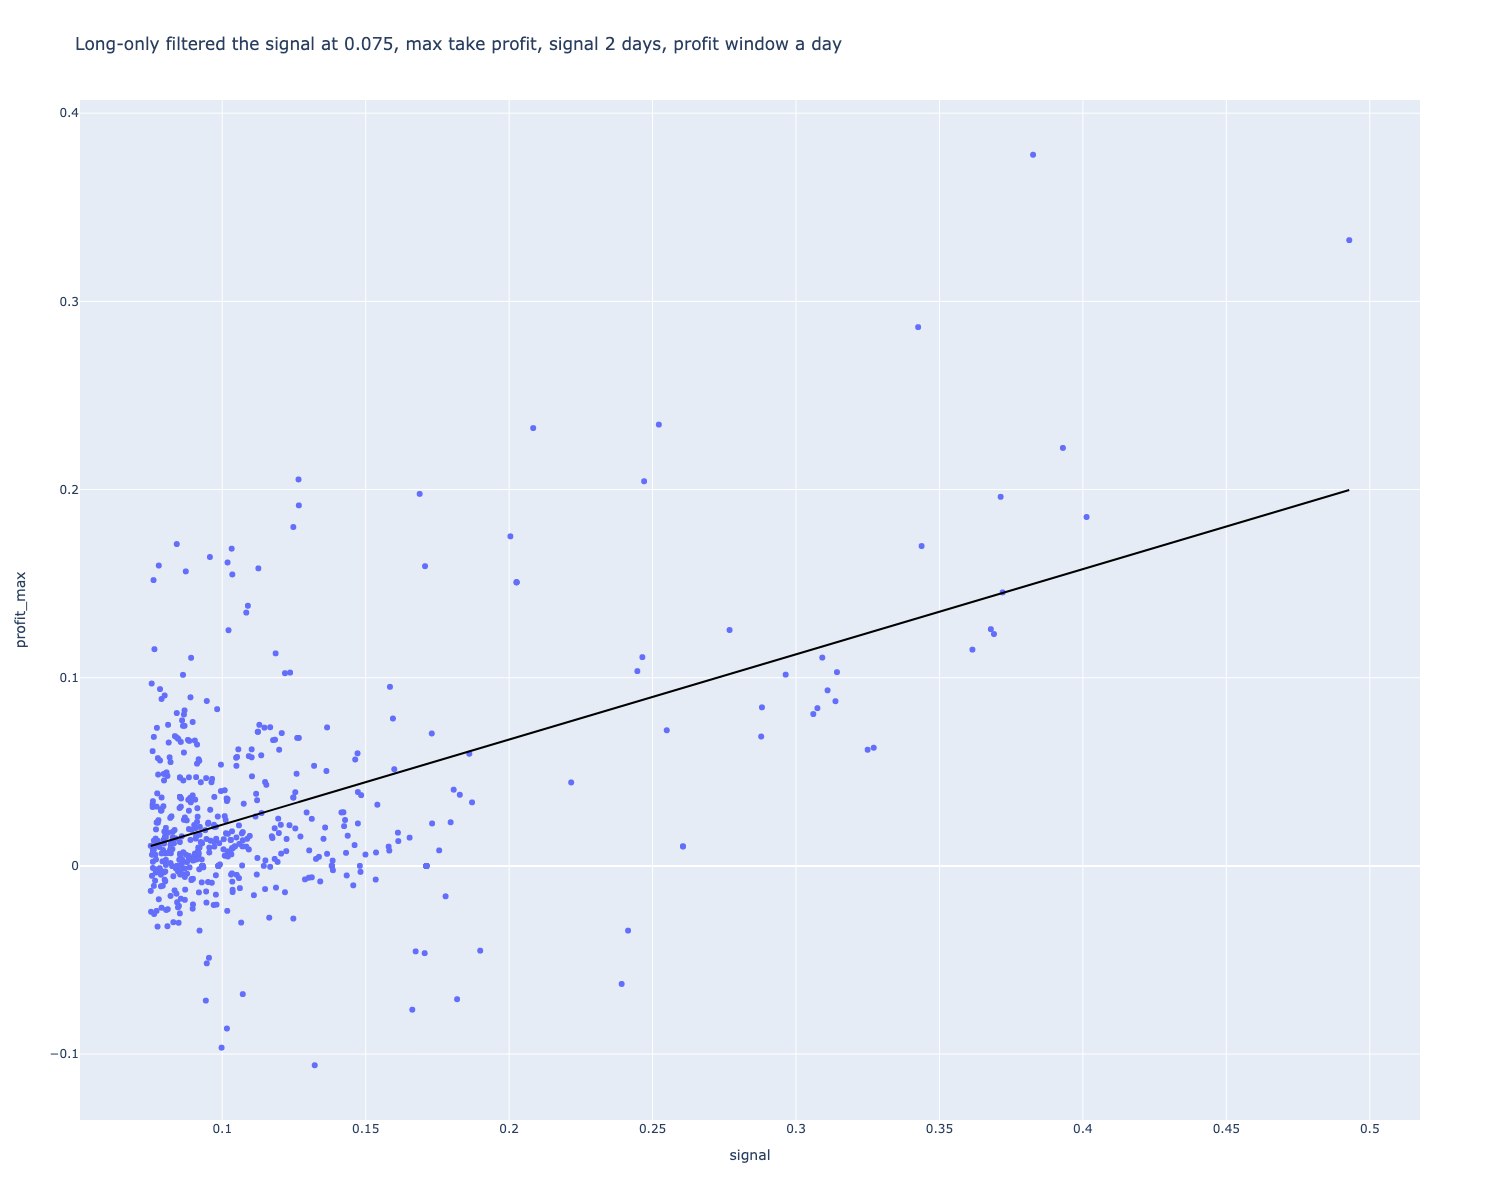

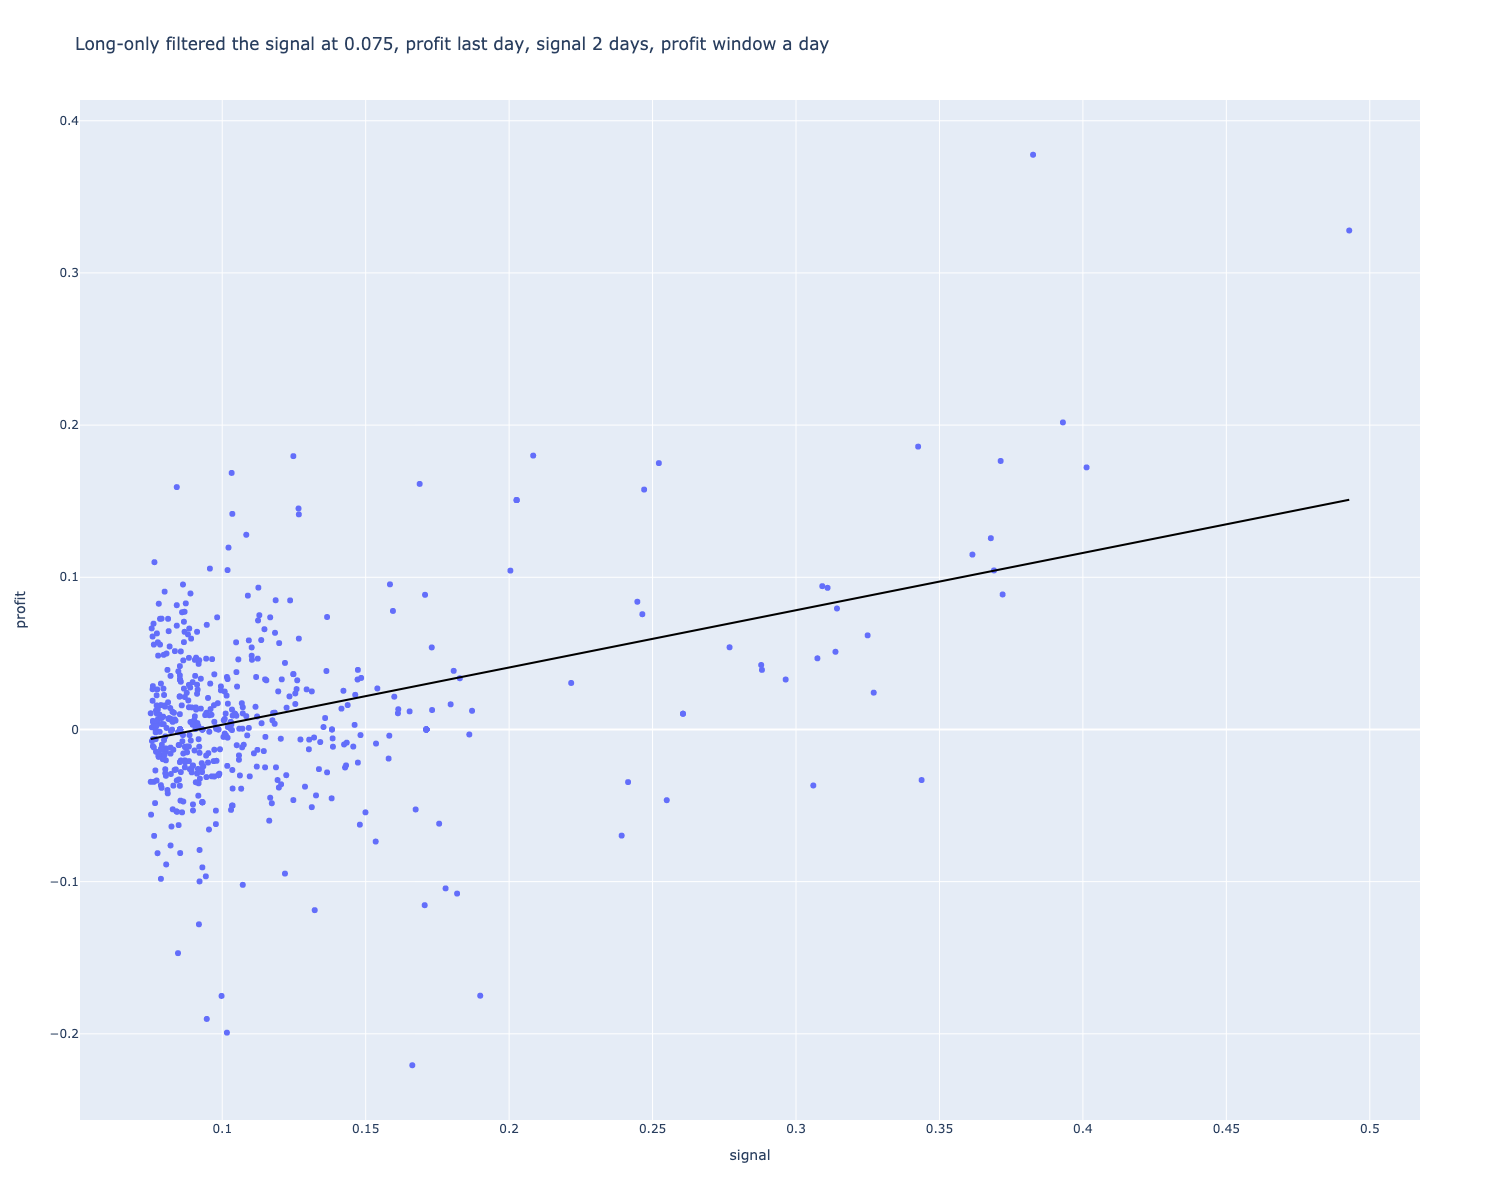

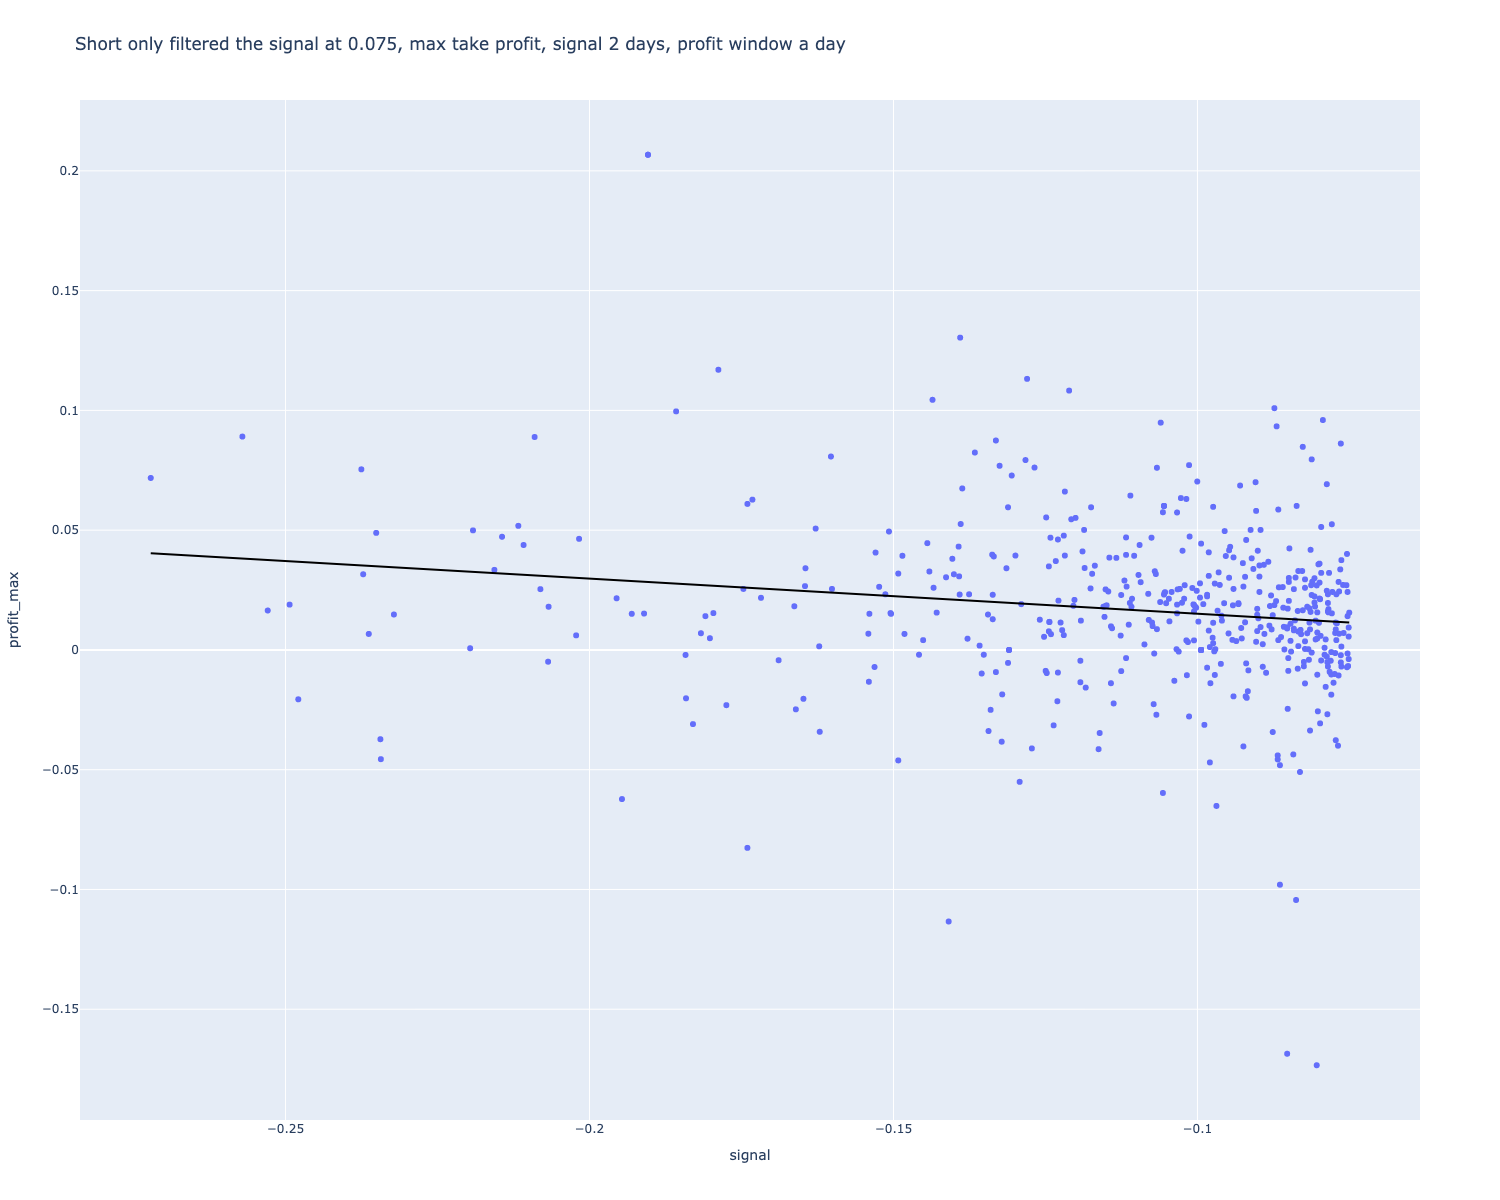

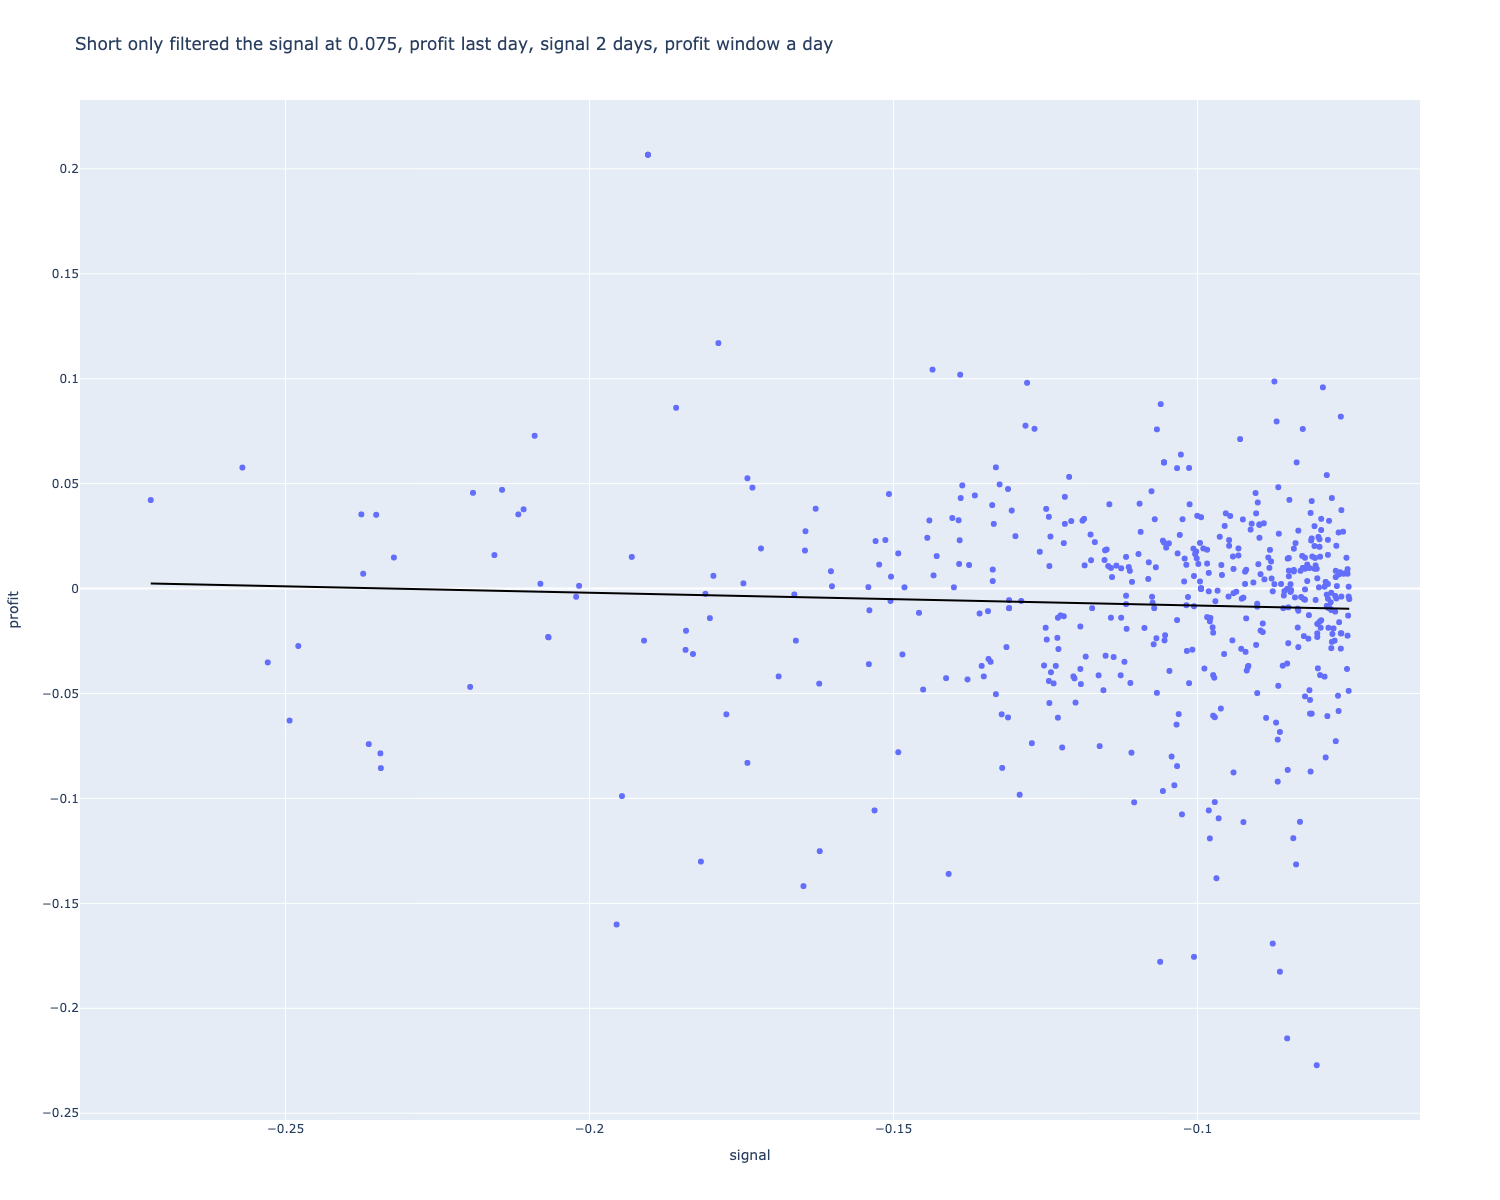

In [72]:

threshold = 0.075

filtered_df = df_long_only.loc[abs(df_long_only["signal"]) >= threshold]

fig = px.scatter(
    filtered_df, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Long-only filtered the signal at {threshold}, max take profit, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

fig = px.scatter(
    filtered_df, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Long-only filtered the signal at {threshold}, profit last day, signal {signal_window_label}, profit window {profit_window_label}")
fig.show()

fig = px.scatter(
    filtered_df, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"No filter, profit last day, signal {signal_window_label}, profit window {profit_window_label}")
fig.show()

filtered_df = df_short_only.loc[abs(df_short_only["signal"]) >= threshold]

fig = px.scatter(
    filtered_df, 
    x="signal", 
    y="profit_max", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Short only filtered the signal at {threshold}, max take profit, signal {signal_window_label}, profit window {profit_window_label}"
)
fig.show()

fig = px.scatter(
    filtered_df, 
    x="signal", 
    y="profit", 
    trendline="ols", 
    trendline_color_override="black", 
    title=f"Short only filtered the signal at {threshold}, profit last day, signal {signal_window_label}, profit window {profit_window_label}")
fig.show()

## Heatmap

Invidual point cloud is hard to interpret, so render it as a heatmap instead.

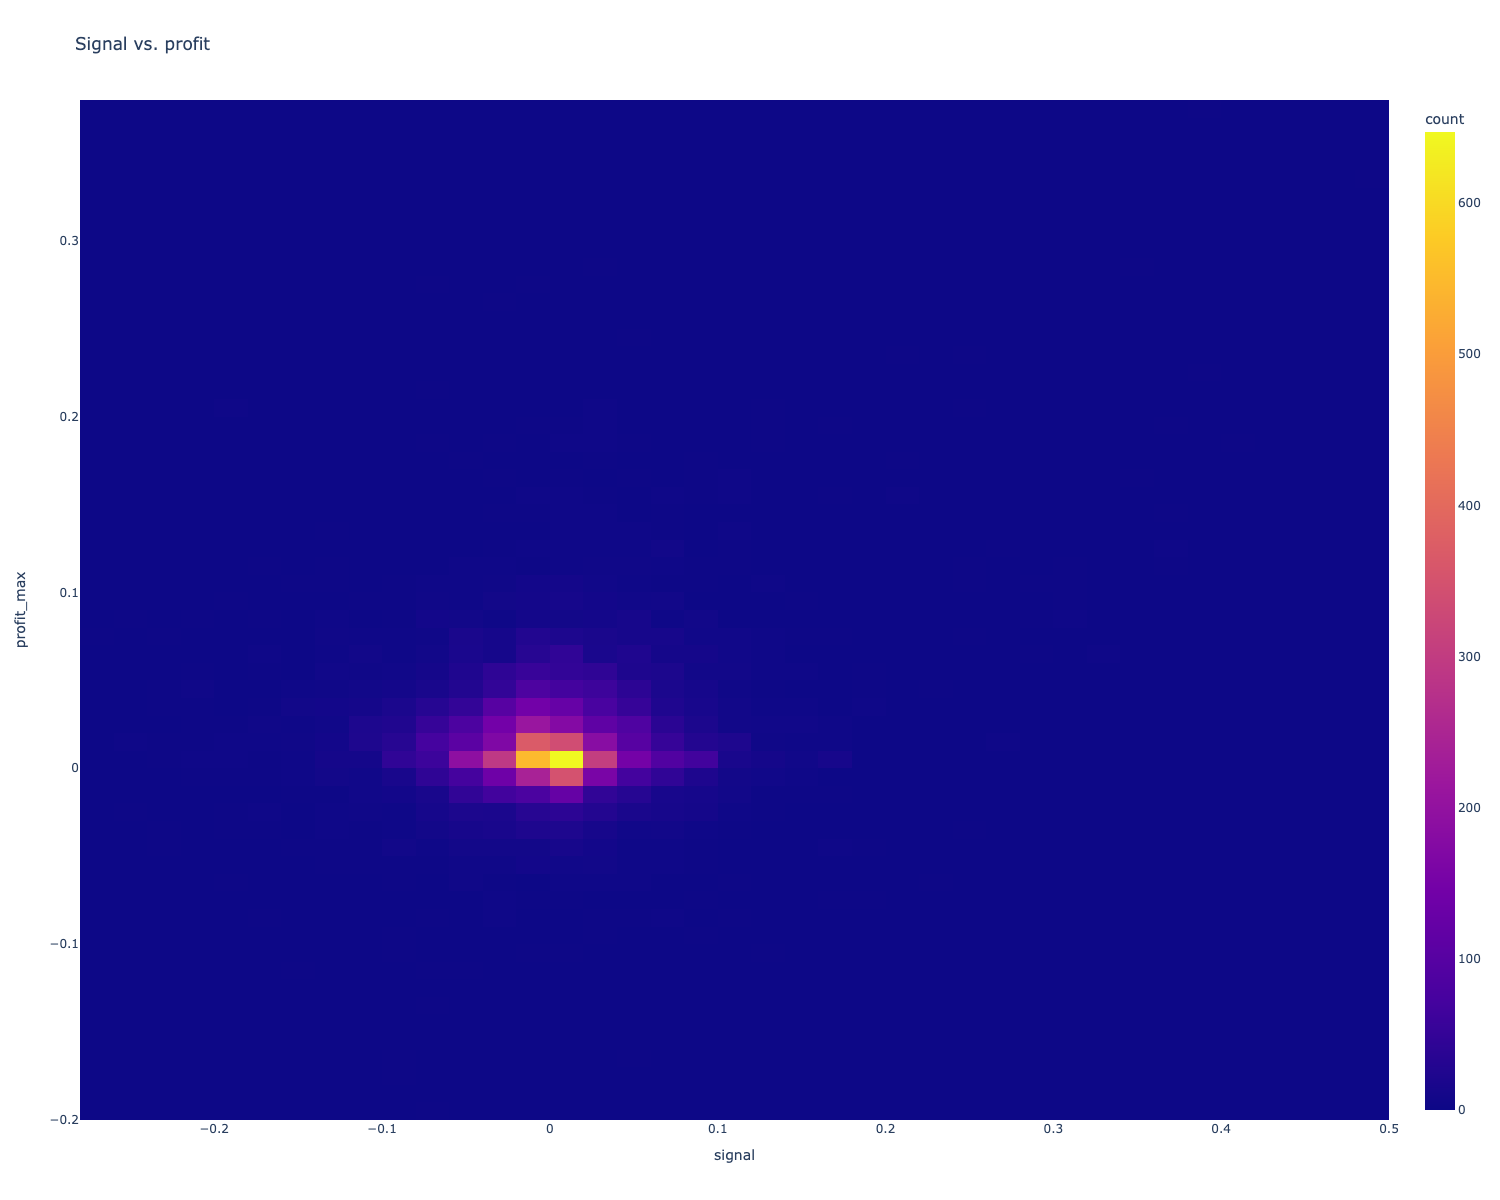

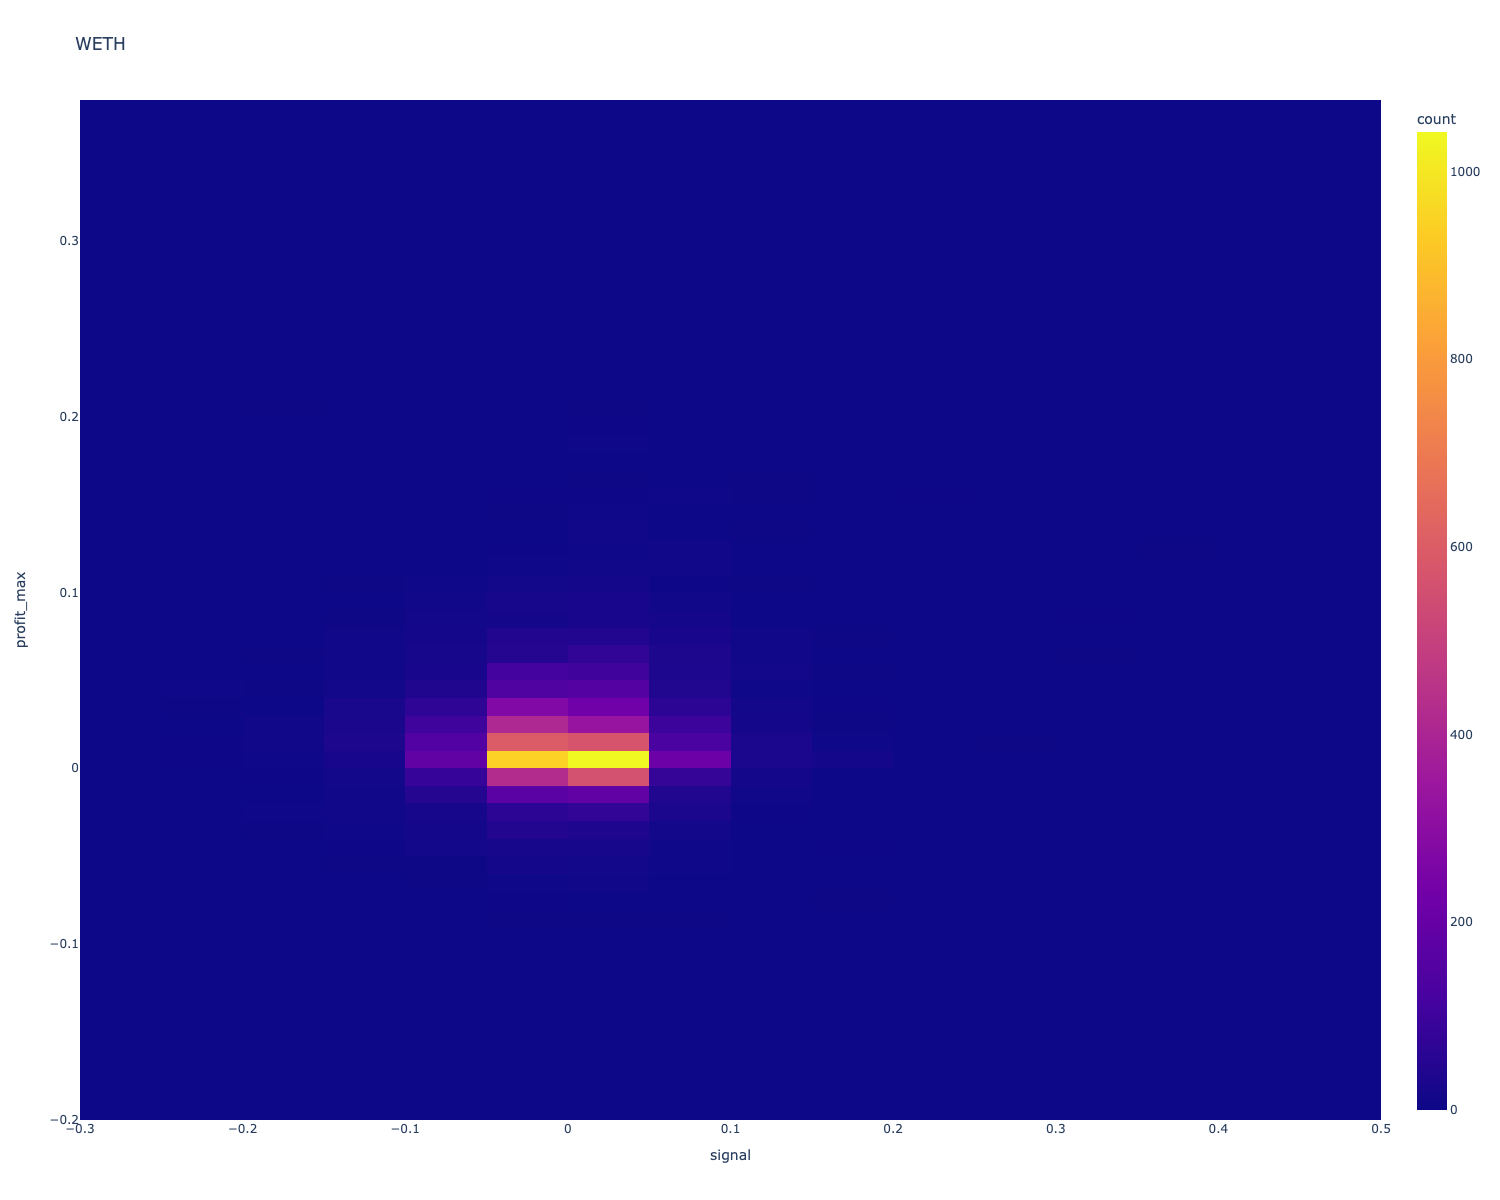

In [65]:
fig = px.density_heatmap(df, x="signal", y="profit_max", nbinsx=60, title="Signal vs. profit")
fig.show()


weth = df.loc[df["pair"] == "WETH-UDSC long"]
fig = px.density_heatmap(df, x="signal", y="profit_max", nbinsx=30, title="WETH")
fig.show()

## Hexbin plot

Try to make more sense from the point cloud.

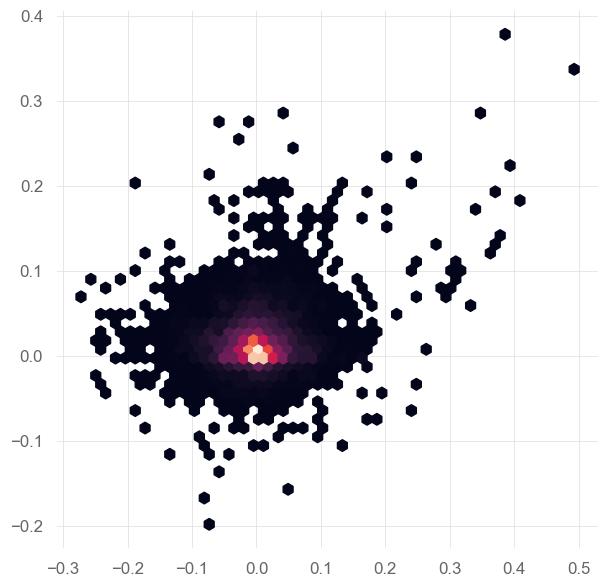

In [66]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import cmocean#  http://matplotlib.org/cmocean/

plt.figure(figsize=(7, 7))
ax = plt.hexbin(df["signal"], df["profit_max"], gridsize=50, mincnt=1) # cmocean.cm.algae is a cmocean colormap
# plt.set_title("Signal vs. Price matches")
plt.show()
# display(df)